In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
train_data_directory = 'C:/Users/Jenny/Dropbox/Data/Dog_Breeds'

In [3]:
# image data preprocessing
image_size = (160,160)

batch_size = 64


class_mode = 'categorical' # for multi-class classification problem, use: class_mode = 'categorical' or "binary"


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
     rotation_range=90,
     rescale=1./255,
     shear_range=0.5,
     zoom_range=0.5,
     width_shift_range=0.5,
     height_shift_range=0.5,
     horizontal_flip=True,
     vertical_flip=True,
     fill_mode="nearest",
     validation_split=0.2 # set validation split
    ) 

train_generator = train_datagen.flow_from_directory(
    train_data_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_directory, # same directory as training data
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode, # for multi-class classification problem, use 'category'
    subset='validation') # set as validation data

Found 9501 images belonging to 5 classes.
Found 2373 images belonging to 5 classes.


In [4]:
# build a model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(160, 160, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

inputs = tf.keras.Input(shape=(160, 160, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [5]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [6]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("dog_breeds_transfer_MobileNetV2.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=1,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000000001)

In [7]:
# load previously trained model
# from tensorflow import keras
# model = keras.models.load_model('C:/Users/Jenny/python/dog_breeds_transfer_MobileNetV2.h5')

In [8]:
# fit/train model

nb_epochs = 1000

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[checkpoint, early, learning_rate_reduction])

Epoch 1/1000
148/148 [==============================] - 158s 1s/step - loss: 1.0137 - accuracy: 0.6027 - val_loss: 0.8248 - val_accuracy: 0.6778

Epoch 00001: val_accuracy improved from -inf to 0.67779, saving model to dog_breeds_transfer_MobileNetV2.h5
Epoch 2/1000


C:\Users\Jenny\miniconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


148/148 [==============================] - 115s 781ms/step - loss: 0.7747 - accuracy: 0.7010 - val_loss: 0.7864 - val_accuracy: 0.6947

Epoch 00002: val_accuracy improved from 0.67779 to 0.69468, saving model to dog_breeds_transfer_MobileNetV2.h5
Epoch 3/1000
148/148 [==============================] - 115s 780ms/step - loss: 0.7641 - accuracy: 0.7051 - val_loss: 0.6844 - val_accuracy: 0.7331

Epoch 00003: val_accuracy improved from 0.69468 to 0.73311, saving model to dog_breeds_transfer_MobileNetV2.h5
Epoch 4/1000
148/148 [==============================] - 117s 789ms/step - loss: 0.7312 - accuracy: 0.7129 - val_loss: 0.7206 - val_accuracy: 0.7331

Epoch 00004: val_accuracy did not improve from 0.73311

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/1000
148/148 [==============================] - 114s 773ms/step - loss: 0.7100 - accuracy: 0.7250 - val_loss: 0.7193 - val_accuracy: 0.7264

Epoch 00005: val_accuracy did not improve from 0.73311

Ep

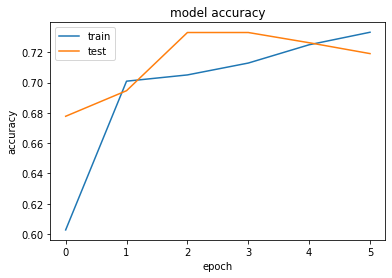

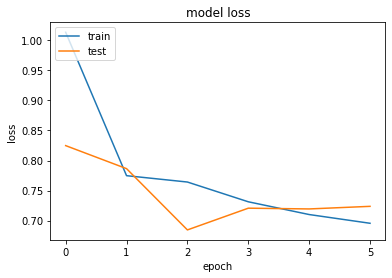

In [9]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes to the `trainable` attribute of any inner layer, so that your changes are take into account
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

# Train end-to-end. Be careful to stop before you overfit!
nb_epochs = 1000
history2 = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[checkpoint, early, learning_rate_reduction])

Epoch 1/1000
148/148 [==============================] - 118s 773ms/step - loss: 0.6293 - accuracy: 0.7651 - val_loss: 0.6143 - val_accuracy: 0.7652

Epoch 00001: val_accuracy improved from 0.73311 to 0.76520, saving model to dog_breeds_transfer_MobileNetV2.h5


C:\Users\Jenny\miniconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/1000
148/148 [==============================] - 115s 774ms/step - loss: 0.5722 - accuracy: 0.7822 - val_loss: 0.5725 - val_accuracy: 0.7762

Epoch 00002: val_accuracy improved from 0.76520 to 0.77618, saving model to dog_breeds_transfer_MobileNetV2.h5
Epoch 3/1000
148/148 [==============================] - 112s 757ms/step - loss: 0.5554 - accuracy: 0.7861 - val_loss: 0.5656 - val_accuracy: 0.7758

Epoch 00003: val_accuracy did not improve from 0.77618

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 4/1000
148/148 [==============================] - 112s 757ms/step - loss: 0.5196 - accuracy: 0.8049 - val_loss: 0.5336 - val_accuracy: 0.7859

Epoch 00004: val_accuracy improved from 0.77618 to 0.78590, saving model to dog_breeds_transfer_MobileNetV2.h5
Epoch 5/1000
148/148 [==============================] - 111s 753ms/step - loss: 0.5033 - accuracy: 0.8125 - val_loss: 0.5391 - val_accuracy: 0.7918

Epoch 00005: val_accuracy improved from 0.7859

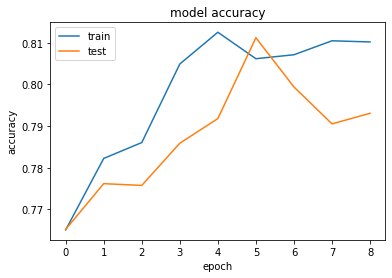

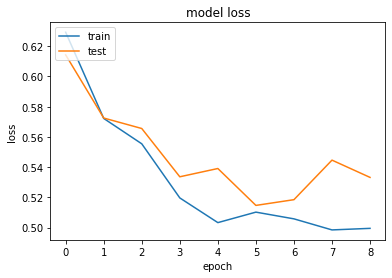

In [11]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()